<a href="https://colab.research.google.com/github/awaiskhan005/DATA-SCIENCE-AND-AI-/blob/main/LSTM_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Load the dataset
df = pd.read_csv('/content/sample_data/SMCI (6).csv')


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


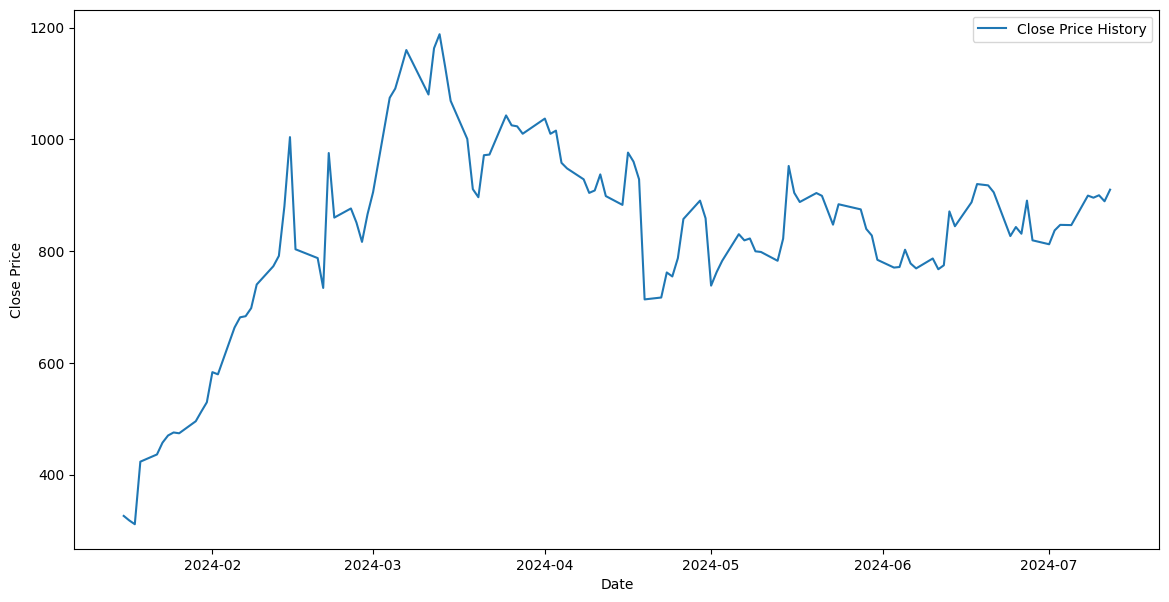

In [25]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values (if any)
df = df.fillna(method='ffill')

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the date as the index
df.set_index('Date', inplace=True)

# Plot the closing price to visualize the data
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


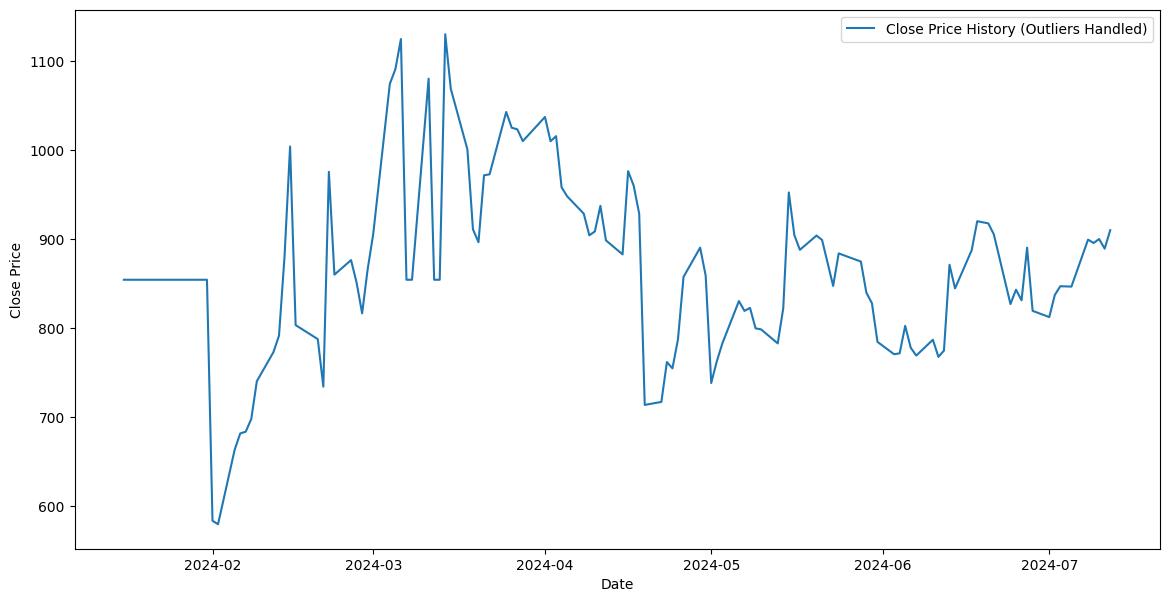

In [26]:
# prompt: handle outliers from the data

# Calculate the IQR for 'Close' price
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['Close'] < lower_bound) | (df['Close'] > upper_bound)]

# Option 1: Remove outliers
df_no_outliers = df[~((df['Close'] < lower_bound) | (df['Close'] > upper_bound))]

# Option 2: Replace outliers with median (or another suitable value)
median_close = df['Close'].median()
df['Close'] = np.where((df['Close'] < lower_bound) | (df['Close'] > upper_bound),
                       median_close, df['Close'])

# Plot the data after handling outliers (choose one of the options above)
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price History (Outliers Handled)')  # Or use df_no_outliers
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


              Open         High          Low        Close    Adj Close  \
count   124.000000   124.000000   124.000000   124.000000   124.000000   
mean    835.124596   866.847903   801.559599   865.596125   835.060399   
std     179.316496   182.971718   169.155111    99.788263   174.403804   
min     320.510010   322.000000   305.750000   579.630005   311.440002   
25%     776.769989   801.897507   751.150024   803.120010   774.307495   
50%     852.350006   890.675019   824.815002   854.274994   854.274994   
75%     925.050003   971.342514   885.732499   906.244979   918.232514   
max    1212.000000  1229.000000  1122.339966  1130.109985  1188.069946   

             Volume  
count  1.240000e+02  
mean   8.816169e+06  
std    5.630754e+06  
min    2.814700e+06  
25%    5.039050e+06  
50%    6.791700e+06  
75%    1.147642e+07  
max    3.380240e+07  


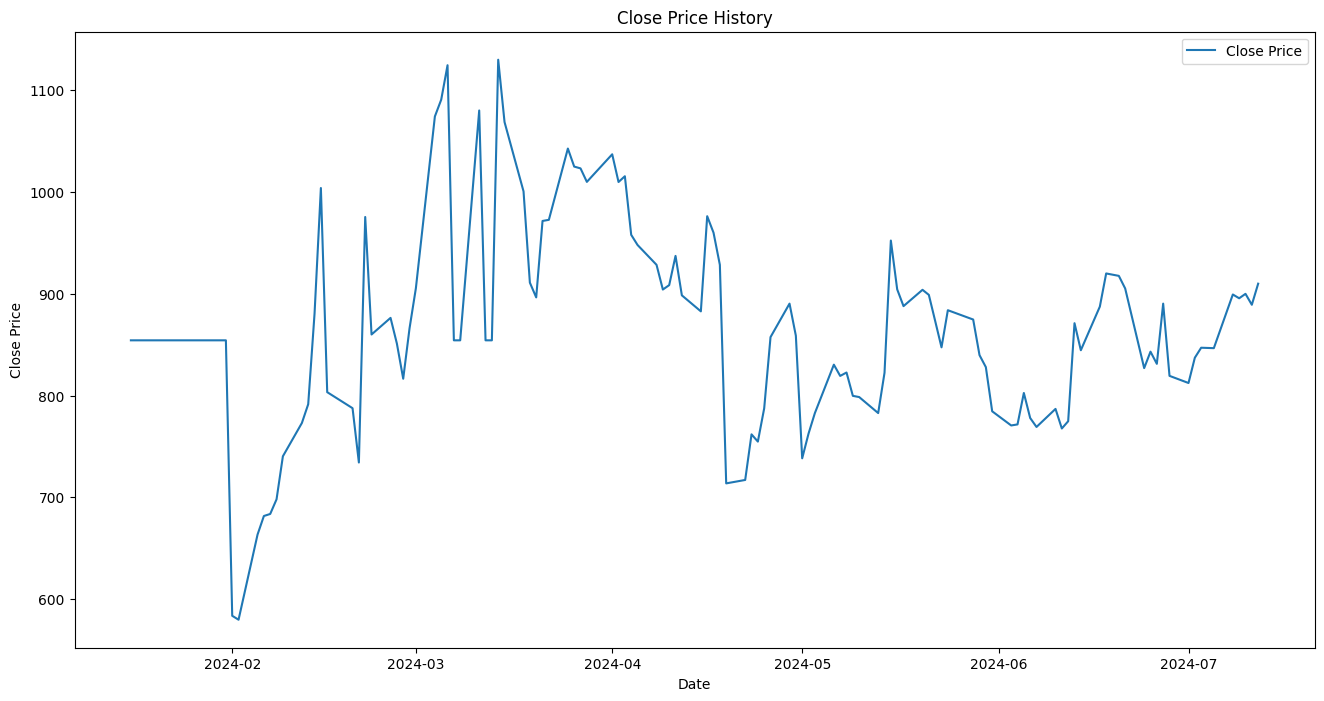

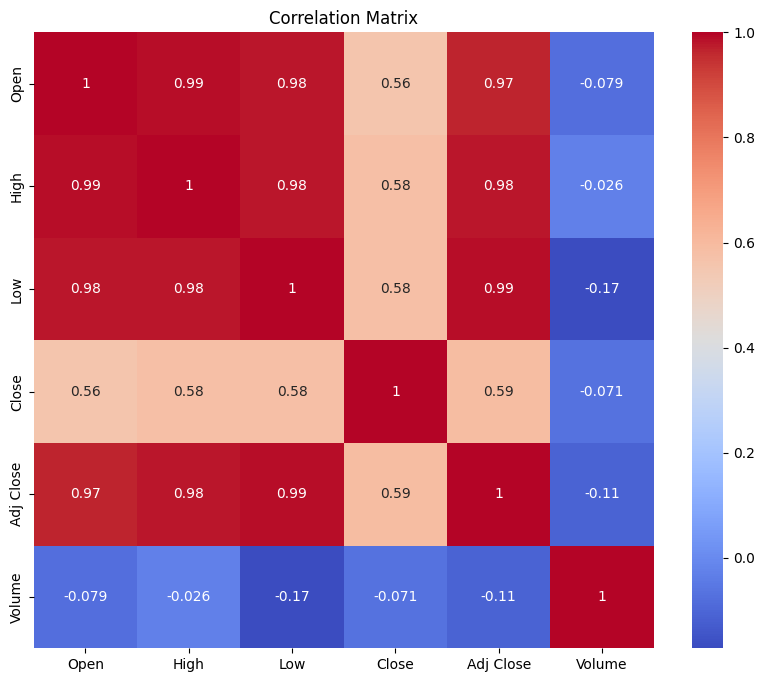

In [27]:
# Summary statistics
print(df.describe())

# Plotting the closing price
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [30]:
# Creating a new dataframe with only the 'Close' column
data = df.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [31]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


58/58 [==============================] - 6s 26ms/step - loss: 0.0255


1/1 [==============================] - 1s 1s/step
RMSE:  54.84426005560638


<ipython-input-32-748b020be173>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


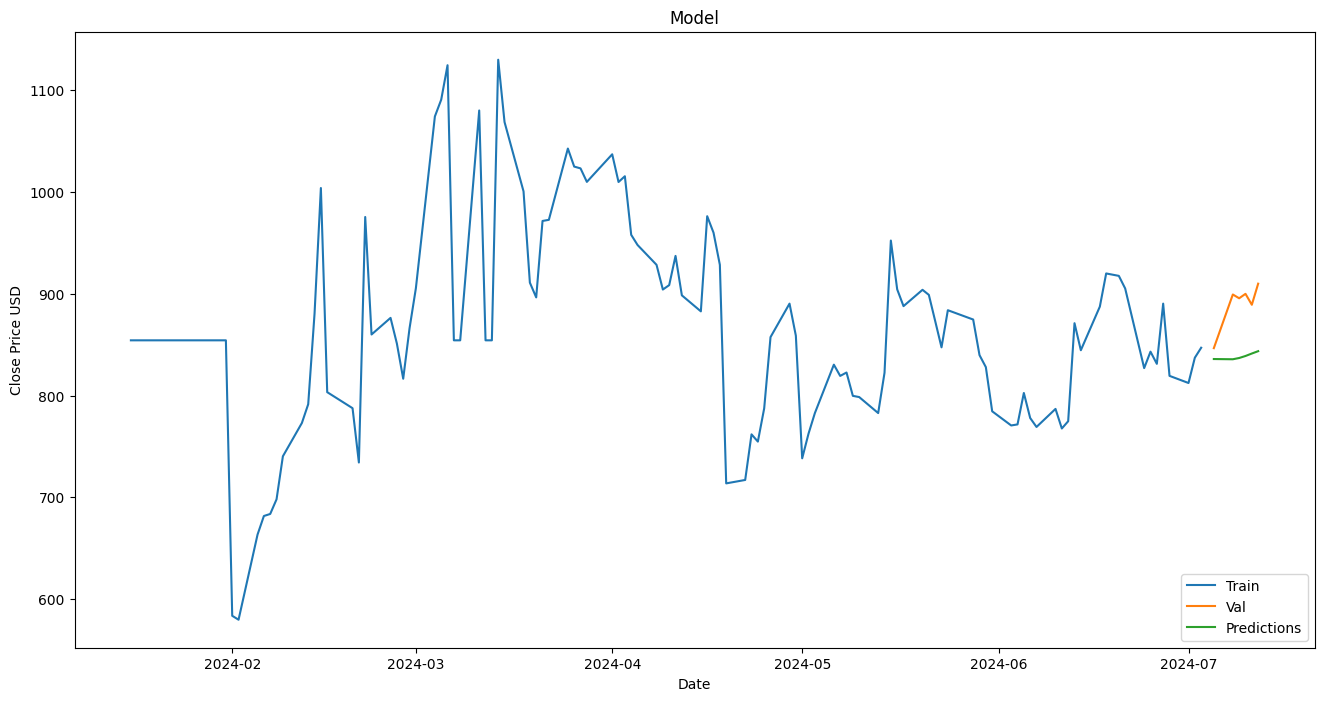

In [32]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('RMSE: ', rmse)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [33]:
# prompt: print the accuracy of lstm

# Calculate the accuracy (R-squared score)
from sklearn.metrics import r2_score
accuracy = r2_score(y_test, predictions)
print('Accuracy (R-squared score): ', accuracy)


Accuracy (R-squared score):  -6.211631617446104


In [34]:
# Get the last 60 days closing price values and scale them
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

# Create an empty list
X_test = []
X_test.append(last_60_days_scaled)

# Convert the X_test data set to a numpy array
X_test = np.array(X_test)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)

print(f'Predicted Close Price for the next day: {pred_price}')

# Predict the next 7 days
pred_prices = []
for i in range(7):
    X_test = np.array(X_test)
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    pred_prices.append(pred_price[0][0])

    new_day = np.append(X_test[0, 1:], pred_price)
    new_day = new_day.reshape(1, -1)
    X_test = np.append(X_test[0, 1:], pred_price).reshape(1, 60, 1)

print(f'Predicted Close Prices for the next 7 days: {pred_prices}')


1/1 [==============================] - 0s 26ms/step
Predicted Close Price for the next day: [[846.2474]]
1/1 [==============================] - 0s 25ms/step
Predicted Close Prices for the next 7 days: [846.2474, 880.4531, 900.0766, 907.50964, 907.8511, 904.5572, 899.705]


In [35]:
# prompt: print the predict next values with its dates

# ... (preceding code)

# Predict the next 7 days with dates
last_date = df.index[-1]
next_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)
pred_prices_with_dates = pd.DataFrame({'Date': next_dates, 'Predicted Close': pred_prices})

print(pred_prices_with_dates)


        Date  Predicted Close
0 2024-07-13       846.247375
1 2024-07-14       880.453125
2 2024-07-15       900.076599
3 2024-07-16       907.509644
4 2024-07-17       907.851074
5 2024-07-18       904.557190
6 2024-07-19       899.705017
